# MMRD Analysis

In [2]:
%load_ext autoreload
%autoreload 2
# Import libraries
import pandas as pd
import numpy as np
import sys
import glob
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, ttest_ind, fisher_exact
from statsmodels.stats.multitest import multipletests
import json
import itertools
import os
import signatureanalyzer as sa
import rpy2
import re
%load_ext rpy2.ipython

sys.path.append("../funcs/")
import utils
import proteomics as prot
import plotting as pl
import ms_utils

sys.path.append("../scripts/")
import diffexp_wrapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [38]:
KEGG_PATH = '../data/genesets/c2.cp.kegg.v7.4.symbols.gmt'
HALLMARK_PATH = '../data/genesets/h.all.v7.4.symbols.gmt'
REACTOME_PATH = '../data/genesets/ReactomePathways_ddr.gmt'
GENESET_PATH = "../data/genesets/full_geneset.json"
FEATURE_MAP = "../data/var_map_full_v4.tsv"

H_MUT_PATH = "results/Full_H_compressed_v2.tsv"
SAMPLE_MAP_PATH = "../data/ref/PanCan_Participant_freeze_mapping.tsv"
DENDRO_PATH = "../data/dendrogram_split_map.tsv"

MAF_PATH = "../data/union_somatic_maf_v1.1_hotspot_cptac2fix.maf"

# Data paths: These files must be downloaded, 
# and the paths must be changed to their corresponding path on the local machine
RNA_PATH = "../data/raw/tumor_rna_counts_pc_X.tsv"
PROTEOME_RAW_PATH = "../data/raw/proteome_gene_centric.tsv.gz"
PHOSPHO_CORRECTED_PATH = "../data/ptm_residuals/phosphoproteome_raw_res_X.tsv"
ACETYL_CORRECTED_PATH = "../data/ptm_residuals/acetylome_raw_res_X.tsv"
PHOSPHO_RAW_PATH = "../data/raw/phosphoproteome_X.tsv.gz"
ACETYL_RAW_PATH = "../data/raw/acetylome_X.tsv.gz"
RNA_TPM_PATH = "../data/raw/tumor_rna_tpm_X.parquet"


In [4]:
# Load geneset
gs_d = {}
with open(GENESET_PATH, "r") as f:
    gs_d = json.load(f)


In [5]:
# Load relevant data
H_mut = pd.read_csv(H_MUT_PATH, sep='\t',index_col=0)
dendrogroup_map = pd.read_csv(DENDRO_PATH, sep='\t', index_col=0)
sample_map = pd.read_csv(SAMPLE_MAP_PATH, sep='\t')
dendrogroup_map.index = dendrogroup_map.index.astype(str)
sample_map.index = sample_map.index.astype(str)

#  Annotate with cohort
dendrogroup_map['cohort'] = dendrogroup_map.index.map(
    sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort'])

# Standardize sample naming schema
H_mut.index = H_mut.index.map(sample_map.set_index('WXS').to_dict()['Proteome_Sample_ID']).astype(str)

# Subset for patients with mutational data and dendro data
not_shared = [x for x in H_mut.index if x not in dendrogroup_map.index.to_list()]
print(f"Patients with mutation data but no dendro data: {not_shared}")
H_mut = H_mut.loc[np.intersect1d(H_mut.index, dendrogroup_map.index)]
sample_map = sample_map[sample_map['Proteome_Sample_ID'].isin(H_mut.index.to_list())]

# Define MMRD patients
MMRD_patients = H_mut[H_mut['MMRD']>0].index
POLE_POLD_patients = H_mut[H_mut['POLE']>0].index


Patients with mutation data but no dendro data: ['X03BR011']


In [13]:
def run_MMRD_DE(formats, outDir, pov_id, acetylome=False, subset=None):
    formats["out_limma"] = os.path.join(outDir, "analysis_files")
    diffexp_wrapper.run_differential_expression(formats=formats, scripts_dir=formats["scripts_dir"])
    
    # Make qq-plots
    protein_map = pd.read_csv("/home/yakiyama/DE_data/var_map_full_v2.tsv",sep='\t',index_col='id')
    full_de_df = pd.read_csv(os.path.join(outDir, "analysis_files", "full_diffexp_results.tsv"),sep='\t',index_col=0)
    full_de_df['feature'] = full_de_df['feature'].map(lambda x: x if x==x  else 'proteome')
    full_de_df['gene_name'] = full_de_df.apply(lambda x: x['gene_name'] if x['feature'] in 
                                               ['transcriptome','phosphoproteome','acetylome','phosphoproteome_res',
                                               'acetylome_res'] else x.name, 1) 
    full_de_df.to_csv(os.path.join(outDir, "analysis_files", "full_diffexp_results.tsv"), sep='\t')
    full_de_df = full_de_df[full_de_df['id']==pov_id]
    
    # Subset for genes and recompute FDR
    subset_corrected_df = pd.DataFrame()
    if subset != None:
        subset_df = full_de_df[full_de_df['gene_name'].isin(subset)]
        for feat, feat_df in subset_df.groupby('feature'):
            feat_df['adj.P.Val'] = multipletests(feat_df['P.Value'], method="fdr_bh")[1]
            feat_df['qval'] = prot.qvalue(feat_df['P.Value'])[0]
            subset_corrected_df = pd.concat([subset_corrected_df, feat_df])
        subset_corrected_df.to_csv(os.path.join(outDir, "analysis_files", "DDR_diffexp_results.tsv"), sep='\t')
    
    # Prep GSEA
    rna_gsea_rank = utils.prepGSEA(full_de_df, feature='transcriptome', group=pov_id, rank_col='gsea_rank_p')
    prot_gsea_rank = utils.prepGSEA(full_de_df, feature='proteome', group=pov_id, rank_col='gsea_rank_p')
    phospho_gsea_rank = utils.prepGSEA(full_de_df, feature='phosphoproteome', group=pov_id, rank_col='gsea_rank_p')
    phospho_res_gsea_rank = utils.prepGSEA(full_de_df, feature='phosphoproteome_res', group=pov_id, rank_col='gsea_rank_p')
    if acetylome:
        acetyl_gsea_rank = utils.prepGSEA(full_de_df, feature='acetylome', group=pov_id, rank_col='gsea_rank_p')
        acetyl_res_gsea_rank = utils.prepGSEA(full_de_df, feature='acetylome_res', group=pov_id, rank_col='gsea_rank_p')
    phospho_collapsed = prot.ptm_pval_fdr(full_de_df[(full_de_df['feature']=='phosphoproteome') & 
                                                     ~full_de_df['P.Value'].isna()], protein_map=protein_map,
                                          method='fdr_bh')
    phospho_maxsig_gsea_rank = utils.prepGSEA(phospho_collapsed, feature='phosphoproteome', group=pov_id, rank_col='gsea_rank_p')
    if acetylome:
        acetyl_collapsed = prot.ptm_pval_fdr(full_de_df[(full_de_df['feature']=='acetylome') & 
                                                        ~full_de_df['P.Value'].isna()], protein_map=protein_map,
                                              method='fdr_bh')
        acetyl_maxsig_gsea_rank = utils.prepGSEA(acetyl_collapsed, feature='acetylome', group=pov_id, rank_col='gsea_rank_p')
    phospho_res_collapsed = prot.ptm_pval_fdr(full_de_df[(full_de_df['feature']=='phosphoproteome_res') & 
                                                     ~full_de_df['P.Value'].isna()], protein_map=protein_map,
                                          method='fdr_bh')
    phospho_res_maxsig_gsea_rank = utils.prepGSEA(phospho_res_collapsed, feature='phosphoproteome_res', group=pov_id, rank_col='gsea_rank_p')
    if acetylome:
        acetyl_res_collapsed = prot.ptm_pval_fdr(full_de_df[(full_de_df['feature']=='acetylome_res') & 
                                                         ~full_de_df['P.Value'].isna()], protein_map=protein_map,
                                              method='fdr_bh')
        acetyl_res_maxsig_gsea_rank = utils.prepGSEA(acetyl_res_collapsed, feature='acetylome_res', group=pov_id, rank_col='gsea_rank_p')

    pathway_list = ['KEGG','HALLMARK','REACTOME_DDR']
    pathway_dict = {'KEGG':KEGG_PATH, 'HALLMARK':HALLMARK_PATH, 'REACTOME_DDR':REACTOME_PATH}
    feature_list = ['Transcriptome','Proteome','Phosphoproteome','Phosphoproteome Max Sig',
                   'Phosphoproteome Res.', 'Phosphoproteome Res. Max Sig']
    feature_dict = {'Transcriptome':rna_gsea_rank, 'Proteome':prot_gsea_rank, 'Phosphoproteome':phospho_gsea_rank,
                    'Phosphoproteome Max Sig':phospho_maxsig_gsea_rank, 
                    'Phosphoproteome Res.':phospho_res_gsea_rank,
                    'Phosphoproteome Res. Max Sig':phospho_res_maxsig_gsea_rank,}
    if acetylome:
        feature_list += ['Acetylome', 'Acetylome Max Sig', 'Acetylome Res.', 'Acetylome Res. Max Sig']
        feature_dict['Acetylome'] = acetyl_gsea_rank
        feature_dict['Acetylome Max Sig'] = acetyl_maxsig_gsea_rank
        feature_dict['Acetylome Res.'] = acetyl_res_gsea_rank
        feature_dict['Acetylome Res. Max Sig'] = acetyl_res_maxsig_gsea_rank
    gsea_res = pd.DataFrame(columns=['pathway','pval','padj','ES','NES','nMoreExtreme','size','leadingEdge','qval',
                                    'feature','id','geneset'])
    for pathway in pathway_list:
        for feature in feature_list:
            print(f"Running {feature} on {pathway}")
            temp_df = prot.rfgsea(feature_dict[feature],pathway_dict[pathway]).sort_values(by='qval')
            temp_df['feature'] = feature
            temp_df['geneset'] = pathway
            gsea_res = pd.concat([gsea_res,temp_df])
    gsea_res['id'] = pov_id 
    gsea_res.to_csv(os.path.join(outDir, "analysis_files", "full_gsea.tsv"), sep='\t',index=False)
    

In [8]:
# Setup DE formats
formats = {}
formats["scripts_dir"] = "/home/yakiyama/CPTAC_PanCan_PTM_2023/scripts" # Change to appropriate full path
formats["transcriptome"] = RNA_PATH
formats["proteome"] = PROTEOME_RAW_PATH
formats["phosphoproteome"] = PHOSPHO_RAW_PATH
formats["phosphoproteome_res"] = PHOSPHO_CORRECTED_PATH
formats["acetylome"] = ACETYL_RAW_PATH
formats["acetylome_res"] = PHOSPHO_CORRECTED_PATH
formats["prot_maps"] = FEATURE_MAP
formats["minObs"] = "5"

# Define cohort covariate dataframe
cohort_df = sample_map.set_index('Proteome_Sample_ID')[['cohort']].copy()
cohort_df = cohort_df[cohort_df['cohort'].isin(['COAD', 'UCEC'])]

# Set up dendrosplit mappings
global_dendro_df = dendrogroup_map[dendrogroup_map['cohort'].isin(['COAD', 'UCEC'])].copy()


## 2 Differential Expression
### 2.1 Global Analysis: MMRD vs MMRP

In [ ]:
# Define file paths
DENDRO_GLOBAL_INPUT = "DE_data/MMRD/mmr_membership.tsv"
COVAR_GLOBAL_INPUT = "DE_data/MMRD/covar.tsv"

# Define POLE/POLD-exo*
exclude_s = H_mut[(H_mut['POLE']>0) | (H_mut['POLE+MSI']>0)].index


# Set up inputs
membership_df = global_dendro_df.copy()
membership_df['MMRDvsMMRP'] = membership_df.index.map(lambda x: "MMRDvsMMRP_MMRD" if x in MMRD_patients else 
                                                      "MMRDvsMMRP_MMRP")
membership_df = membership_df[~membership_df.index.isin(exclude_s)]
membership_df.to_csv(DENDRO_GLOBAL_INPUT, sep='\t')
global_cohort_df = cohort_df.copy()
global_cohort_df['extra'] = np.nan
global_cohort_df = global_cohort_df[~global_cohort_df.index.isin(exclude_s)]
global_cohort_df.to_csv(COVAR_GLOBAL_INPUT, sep='\t')

# Inputs
formats["input"] = DENDRO_GLOBAL_INPUT
formats["covar"] = COVAR_GLOBAL_INPUT
formats["out_limma"] = "DE_data/MMRD/"
formats["clust"] = 'MMRDvsMMRP'

# Run DE
run_MMRD_DE(formats=formats, outDir=formats["out_limma"],
            pov_id="MMRDvsMMRP_MMRD", acetylome=True,
            subset=gs_d['DDR'])


### 2.2 Figures (Figure 3F)

In [233]:
mmrd_gsea_df = pd.read_csv("/home/yakiyama/DE_results/020222/MMRD/MMRDvsMMRP_excludePOLEPOLD/analysis_files/full_gsea.tsv",
                           sep='\t')

In [234]:
%R -i mmrd_gsea_df

In [235]:
%%R
library(ggplot2)
library(gridExtra)
library(grid)
library(dplyr)
source("/home/yakiyama/CPTAC_PanCan_PTM_2023/funcs/funcsR.R")


[1] "Missing Pathways"
[1] "KEGG_ENDOMETRIAL_CANCER"


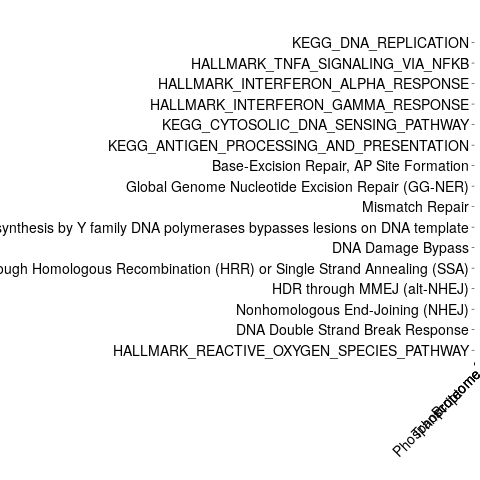

In [236]:
%%R

immune_l <- c('KEGG_INTESTINAL_IMMUNE_NETWORK_FOR_IGA_PRODUCTION',
              'KEGG_JAK_STAT_SIGNALING_PATHWAY','KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION',
              'KEGG_GRAFT_VERSUS_HOST_DISEASE','KEGG_ALLOGRAFT_REJECTION',
              'KEGG_AUTOIMMUNE_THYROID_DISEASE','KEGG_PRIMARY_IMMUNODEFICIENCY',
              'HALLMARK_IL6_JAK_STAT3_SIGNALING','KEGG_CYTOSOLIC_DNA_SENSING_PATHWAY',
              'KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION',
              'KEGG_FC_GAMMA_R_MEDIATED_PHAGOCYTOSIS','KEGG_LEISHMANIA_INFECTION',
              'KEGG_FC_EPSILON_RI_SIGNALING_PATHWAY','KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
              'KEGG_TOLL_LIKE_RECEPTOR_SIGNALING_PATHWAY',
              'KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY',
              'KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY',
              'KEGG_LEUKOCYTE_TRANSENDOTHELIAL_MIGRATION','KEGG_CHEMOKINE_SIGNALING_PATHWAY',
              "KEGG_LYSOSOME",'HALLMARK_INTERFERON_GAMMA_RESPONSE',
              'KEGG_HEMATOPOIETIC_CELL_LINEAGE','HALLMARK_ALLOGRAFT_REJECTION',
              'HALLMARK_IL2_STAT5_SIGNALING','HALLMARK_COMPLEMENT',
              'KEGG_COMPLEMENT_AND_COAGULATION_CASCADES','HALLMARK_COAGULATION',
              'HALLMARK_INTERFERON_ALPHA_RESPONSE', 
              'KEGG_RIG_I_LIKE_RECEPTOR_SIGNALING_PATHWAY')

inflammation_l <- c('KEGG_NOD_LIKE_RECEPTOR_SIGNALING_PATHWAY',
                    'HALLMARK_TNFA_SIGNALING_VIA_NFKB','HALLMARK_INFLAMMATORY_RESPONSE',
                    'KEGG_SYSTEMIC_LUPUS_ERYTHEMATOSUS')
hypoxia_emt_l <- c('HALLMARK_ADIPOGENESIS','HALLMARK_ANGIOGENESIS',
                   'KEGG_ECM_RECEPTOR_INTERACTION','KEGG_CELL_ADHESION_MOLECULES_CAMS',
                   'HALLMARK_HYPOXIA',"HALLMARK_UNFOLDED_PROTEIN_RESPONSE",
                   "KEGG_PROTEASOME",'HALLMARK_APICAL_JUNCTION','KEGG_GAP_JUNCTION',
                   "KEGG_TIGHT_JUNCTION",'KEGG_REGULATION_OF_ACTIN_CYTOSKELETON',
                   'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION','KEGG_FOCAL_ADHESION',
                   'KEGG_VEGF_SIGNALING_PATHWAY','KEGG_NEUROTROPHIN_SIGNALING_PATHWAY',
                   "HALLMARK_HEDGEHOG_SIGNALING","KEGG_HEDGEHOG_SIGNALING_PATHWAY",
                   'KEGG_AXON_GUIDANCE',"KEGG_CALCIUM_SIGNALING_PATHWAY",
                   "KEGG_LONG_TERM_POTENTIATION","HALLMARK_APICAL_SURFACE",
                   "HALLMARK_WNT_BETA_CATENIN_SIGNALING","KEGG_WNT_SIGNALING_PATHWAY",
                   "HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY")

proliferation_l <- c("KEGG_TGF_BETA_SIGNALING_PATHWAY",'HALLMARK_TGF_BETA_SIGNALING',
                     'HALLMARK_MTORC1_SIGNALING','KEGG_ERBB_SIGNALING_PATHWAY',
                     'HALLMARK_ESTROGEN_RESPONSE_EARLY','HALLMARK_ESTROGEN_RESPONSE_LATE',
                     'HALLMARK_ANDROGEN_RESPONSE','KEGG_MAPK_SIGNALING_PATHWAY',
                     "HALLMARK_MITOTIC_SPINDLE","KEGG_RIBOSOME",'HALLMARK_KRAS_SIGNALING_UP',
                     'HALLMARK_KRAS_SIGNALING_DN','HALLMARK_E2F_TARGETS',
                     'HALLMARK_G2M_CHECKPOINT','HALLMARK_MYC_TARGETS_V1',
                     'HALLMARK_MYC_TARGETS_V2','KEGG_GNRH_SIGNALING_PATHWAY',
                     "HALLMARK_NOTCH_SIGNALING","KEGG_CELL_CYCLE","KEGG_DNA_REPLICATION",
                     "KEGG_SPLICEOSOME","KEGG_P53_SIGNALING_PATHWAY",
                     "HALLMARK_P53_PATHWAY",'HALLMARK_APOPTOSIS')
metabolism_l <- c("KEGG_REGULATION_OF_AUTOPHAGY",'KEGG_TYROSINE_METABOLISM',
                  'HALLMARK_FATTY_ACID_METABOLISM',"KEGG_FATTY_ACID_METABOLISM",
                  "KEGG_ARACHIDONIC_ACID_METABOLISM",'KEGG_PPAR_SIGNALING_PATHWAY',
                  'HALLMARK_PEROXISOME','HALLMARK_BILE_ACID_METABOLISM',
                  'KEGG_BUTANOATE_METABOLISM',"KEGG_MELANOGENESIS",
                  "KEGG_PHENYLALANINE_METABOLISM","KEGG_TERPENOID_BACKBONE_BIOSYNTHESIS",
                  'KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION',"KEGG_TRYPTOPHAN_METABOLISM",
                  'HALLMARK_OXIDATIVE_PHOSPHORYLATION','HALLMARK_MYOGENESIS',
                  'KEGG_GLYCOLYSIS_GLUCONEOGENESIS','KEGG_RETINOL_METABOLISM',
                  'KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY',"KEGG_PROPANOATE_METABOLISM",
                  "KEGG_PYRIMIDINE_METABOLISM","KEGG_OXIDATIVE_PHOSPHORYLATION",
                  "KEGG_AMINO_SUGAR_AND_NUCLEOTIDE_SUGAR_METABOLISM",
                  "KEGG_INSULIN_SIGNALING_PATHWAY","KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM",
                  "HALLMARK_GLYCOLYSIS","HALLMARK_CHOLESTEROL_HOMEOSTASIS",
                  "HALLMARK_HEME_METABOLISM","KEGG_INOSITOL_PHOSPHATE_METABOLISM",
                  'KEGG_UBIQUITIN_MEDIATED_PROTEOLYSIS',"KEGG_GLYCEROPHOSPHOLIPID_METABOLISM",
                  "KEGG_ARGININE_AND_PROLINE_METABOLISM",
                  'KEGG_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_CHONDROITIN_SULFATE',
                  "KEGG_STEROID_HORMONE_BIOSYNTHESIS","KEGG_ASCORBATE_AND_ALDARATE_METABOLISM",
                  "KEGG_STARCH_AND_SUCROSE_METABOLISM",
                  "KEGG_PORPHYRIN_AND_CHLOROPHYLL_METABOLISM",
                  "KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS","KEGG_ENDOCYTOSIS",
                  "KEGG_LYSINE_DEGRADATION","KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM",
                  "KEGG_CITRATE_CYCLE_TCA_CYCLE","KEGG_AMINOACYL_TRNA_BIOSYNTHESIS",
                  "KEGG_PANTOTHENATE_AND_COA_BIOSYNTHESIS","KEGG_RNA_DEGRADATION",
                  "KEGG_ABC_TRANSPORTERS","KEGG_O_GLYCAN_BIOSYNTHESIS",
                  "KEGG_ETHER_LIPID_METABOLISM"
                  )
misc_l <- c("KEGG_RNA_POLYMERASE","KEGG_PROTEIN_EXPORT",'HALLMARK_XENOBIOTIC_METABOLISM',
            'KEGG_METABOLISM_OF_XENOBIOTICS_BY_CYTOCHROME_P450',
            'KEGG_DRUG_METABOLISM_CYTOCHROME_P450','KEGG_OOCYTE_MEIOSIS',
            'KEGG_CARDIAC_MUSCLE_CONTRACTION','KEGG_VIRAL_MYOCARDITIS',
            'KEGG_TYPE_I_DIABETES_MELLITUS','KEGG_ASTHMA','KEGG_NON_SMALL_CELL_LUNG_CANCER',
            'KEGG_GLIOMA','KEGG_PATHWAYS_IN_CANCER','HALLMARK_SPERMATOGENESIS',
            'KEGG_ARRHYTHMOGENIC_RIGHT_VENTRICULAR_CARDIOMYOPATHY_ARVC',
            "KEGG_PROGESTERONE_MEDIATED_OOCYTE_MATURATION","KEGG_TASTE_TRANSDUCTION",
            "KEGG_HYPERTROPHIC_CARDIOMYOPATHY_HCM",'KEGG_DILATED_CARDIOMYOPATHY',
            'KEGG_HUNTINGTONS_DISEASE', "KEGG_PARKINSONS_DISEASE", "KEGG_ALZHEIMERS_DISEASE",
            "KEGG_VASCULAR_SMOOTH_MUSCLE_CONTRACTION","HALLMARK_PANCREAS_BETA_CELLS",
            'KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION',"KEGG_OLFACTORY_TRANSDUCTION",
            "KEGG_MELANOMA","KEGG_MATURITY_ONSET_DIABETES_OF_THE_YOUNG",
            "KEGG_DRUG_METABOLISM_OTHER_ENZYMES","KEGG_THYROID_CANCER",
            "KEGG_COLORECTAL_CANCER","KEGG_LONG_TERM_DEPRESSION","KEGG_BLADDER_CANCER",
            "KEGG_BASAL_CELL_CARCINOMA","KEGG_ONE_CARBON_POOL_BY_FOLATE",
            "KEGG_TYPE_II_DIABETES_MELLITUS","KEGG_BASAL_TRANSCRIPTION_FACTORS",
            "KEGG_ACUTE_MYELOID_LEUKEMIA","KEGG_CHRONIC_MYELOID_LEUKEMIA",
            "KEGG_PROSTATE_CANCER")
ddr_l <- c("DNA Double Strand Break Response","Fanconi Anemia Pathway",
           "Nonhomologous End-Joining (NHEJ)","HDR through MMEJ (alt-NHEJ)",
           "HDR through Homologous Recombination (HRR) or Single Strand Annealing (SSA)",
           "Homology Directed Repair","KEGG_HOMOLOGOUS_RECOMBINATION","DNA Damage Bypass",
           "Translesion synthesis by Y family DNA polymerases bypasses lesions on DNA template","Recognition of DNA damage by PCNA-containing replication complex",
           "Resolution of Abasic Sites (AP sites)","Base Excision Repair",
           "KEGG_BASE_EXCISION_REPAIR","KEGG_MISMATCH_REPAIR",
           "Mismatch repair (MMR) directed by MSH2:MSH3 (MutSbeta)",
           "Mismatch Repair","Mismatch repair (MMR) directed by MSH2:MSH6 (MutSalpha)",
           "Transcription-Coupled Nucleotide Excision Repair (TC-NER)",
           "Global Genome Nucleotide Excision Repair (GG-NER)",
           "KEGG_NUCLEOTIDE_EXCISION_REPAIR","Base-Excision Repair, AP Site Formation",
           "HALLMARK_UV_RESPONSE_UP",'HALLMARK_UV_RESPONSE_DN','HALLMARK_DNA_REPAIR', 
           "DNA Damage Reversal")
pathway_l <- c(misc_l,metabolism_l,hypoxia_emt_l,ddr_l,immune_l,inflammation_l,proliferation_l)

plotGSEA <- function(e_df, pval.thresh=0.1, filter=NULL, palette='RdBu', 
                     h=13, w=15, s_color='black', remove.not.sig=TRUE, order=NA){
    if(!is.null(filter)){
        e_df <- dplyr::filter(e_df, grepl(filter, pathway))
    }

    e_df$sig <- e_df$padj<pval.thresh
    e_df$logpval <- -log10(e_df$padj)

    if(remove.not.sig){
        e_df <- e_df[e_df$pathway %in% e_df[e_df$sig,]$pathway,]
    }

    ### Order axis by dendrogram
    # Load data
    X <- e_df[,c('pathway','feature','id','NES')]
    X$comb <- paste(X$feature,X$id)
    X <- reshape(X[,c('pathway','comb','NES')], timevar='comb', idvar='pathway',
                 direction='wide',)
    rownames(X) <- X$pathway
    X$pathway <- NULL

    X[is.na(X)] <- 0

    # Build the dendrogram
    dend <- as.dendrogram(hclust(d = dist(x = X)))
    dendro.plot <- ggdendrogram(dend,rotate = TRUE)

    # Use dendrogram order to order column
    if (is.na(order)){
        order <- order.dendrogram(dend) # dendrogram order
        e_df$pathway <- factor(x = e_df$pathway, levels = unique(e_df$pathway)[order], 
                               ordered = TRUE)
    } else {
        e_df$pathway <- factor(x = e_df$pathway, levels = order, ordered=TRUE)
    }

    ### Balloonplot
    options(repr.plot.width=w, repr.plot.height=h)

    p <- ggballoonplot(
        e_df,
        x="feature",
        y="pathway",
        fill = "NES",
        size="logpval",
        color=ifelse(e_df$sig==T, s_color, "lightgrey")
        ) +
        scale_fill_distiller(palette=palette, limit = max(abs(e_df$NES)) * c(-1, 1))+
        labs(x="", y="", fill="Enrichment", size="-log10 Adj. P-val") + theme_linedraw() +
        theme(axis.text.x=element_text(angle=45, hjust=1, size=14),
              axis.text.y=element_text(size=14)) +
        facet_grid(. ~ id, scales = "free", space = "free") +
        theme(strip.text.x = element_text(size=16))

    return(p)
}

mmrd_gsea_df$id <- "MMRD vs MMRP"
mmrd_gsea_df <- mmrd_gsea_df[-which(mmrd_gsea_df$feature %in% 
                                    c("Phosphoproteome Max Sig",
                                      "Phosphoproteome Res. Max Sig","Acetylome Max Sig", 
                                      "Acetylome Res. Max Sig", "Acetylome", 
                                      "Acetylome Res.", "Phosphoproteome Res.")), ]
print("Missing Pathways")
for (x in mmrd_gsea_df[which(mmrd_gsea_df$padj <= 0.1), ]$pathway) {
  if (!x %in% pathway_l) {
    print(x)
  }
}
mmrd_extra_pathways_l <- c()
for (x in pathway_l) {
  if (!x %in% mmrd_gsea_df$pathway) {
    append(mmrd_extra_pathways_l,x)
  }
}
mmrd_exclude_l <- c("HALLMARK_MYC_TARGETS_V2","KEGG_NUCLEOTIDE_EXCISION_REPAIR",
                    "Mismatch Repair","KEGG_BASE_EXCISION_REPAIR",
                    "Resolution of Abasic Sites (AP sites)","KEGG_PYRIMIDINE_METABOLISM",
                    "KEGG_ENDOMETRIAL_CANCER","KEGG_BASAL_CELL_CARCINOMA",
                    "KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION","KEGG_RIBOSOME",
                    "KEGG_GRAFT_VERSUS_HOST_DISEASE", "KEGG_CELL_CYCLE", 
                    "HALLMARK_MYC_TARGETS_V1", "HALLMARK_G2M_CHECKPOINT", "HALLMARK_E2F_TARGETS", "HALLMARK_MITOTIC_SPINDLE",
                    "HALLMARK_IL6_JAK_STAT3_SIGNALING", "KEGG_PROTEASOME", 
                    "HALLMARK_UNFOLDED_PROTEIN_RESPONSE", 
                    "Transcription-Coupled Nucleotide Excision Repair (TC-NER)")
mmrd_include <- c("KEGG_DNA_REPLICATION", "Global Genome Nucleotide Excision Repair (GG-NER)", 
                  "Base-Excision Repair, AP Site Formation", "Mismatch Repair", 
                  "Translesion synthesis by Y family DNA polymerases bypasses lesions on DNA template", 
                  "DNA Damage Bypass", "Nonhomologous End-Joining (NHEJ)", 
                  "HDR through MMEJ (alt-NHEJ)", 
                  "HDR through Homologous Recombination (HRR) or Single Strand Annealing (SSA)",
                  "DNA Double Strand Break Response", "HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY", 
                  "HALLMARK_INTERFERON_ALPHA_RESPONSE", 
                  "HALLMARK_TNFA_SIGNALING_VIA_NFKB", "HALLMARK_INTERFERON_GAMMA_RESPONSE", 
                  "KEGG_CYTOSOLIC_DNA_SENSING_PATHWAY", 
                  "KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION")

mmrd_order_l <- pathway_l[!(pathway_l %in% mmrd_extra_pathways_l)]
mmrd_order_l <- pathway_l[pathway_l %in% mmrd_include]
mmrd_gsea_df <- mmrd_gsea_df[which(mmrd_gsea_df$pathway %in% pathway_l),]
mmrd_gsea_df <- mmrd_gsea_df[which(mmrd_gsea_df$pathway %in% mmrd_include), ]

mmrd_gsea_plot <- plotGSEA(mmrd_gsea_df, order=mmrd_order_l)
print(mmrd_gsea_plot)
ggsave("Figure_3F_MMRD_gsea.pdf", mmrd_gsea_plot, path="figures/",
       dpi=100, height=9, width=12)

## 3 MMRD DSB Repair Dysfunction Analysis
Hypothesis: Exonic microsatellites are highly mutable in MMRD tumors. Previous studies have shown microsatellites in ATM, RAD50, and MRE11 lead to impaired DSB repair in MMRD tumors. Recurrent MS-indels in DSB repair genes is responsible for proteomic inactivity of DSB pathways

Fisher exact test for all genes with MS-indels (Maruvka et. al. 2017, Supplementary Table S5) to find significantly mutated MS-indel genes. Subset for frameshift mutation samples and compare with MMRP (UCEC AND COAD). Limit to UCEC and COAD tumors

In [40]:
# Subset MMRD tumors for COAD and UCEC 
proteome2Cohort_d = sample_map.set_index("Proteome_Sample_ID").to_dict()['cohort']
include_mmrd = [x for x in MMRD_patients if (proteome2Cohort_d[x] in ["UCEC",'COAD']) & (x not in POLE_POLD_patients)]

# All samples in MMRP + MMRD 
include_samples = H_mut[H_mut.index.map(proteome2Cohort_d).isin(['UCEC', 'COAD']) & 
                        (H_mut['POLE']==0)].index

# List mmrp samples
include_mmrp = [x for x in include_samples if x not in include_mmrd]


In [48]:
# Import MAF
maf_df = pd.read_csv(MAF_PATH, sep='\t')
wxs2Prot_d = sample_map.set_index("WXS").to_dict()['Proteome_Sample_ID']
maf_df['Tumor_Sample_Barcode'] = maf_df['Tumor_Sample_Barcode'].map(wxs2Prot_d)


/home/yakiyama/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (23,61,74,76,80,81,89,119) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
# Subset maf 
test_genes_l = ['MRE11', 'RAD50', 'NBN', 'ATM']
deleterious_mut_l = ['Frame_Shift_Del', 'Intron', 'Nonsense_Mutation', 
                     'Frame_Shift_Ins', 'Splice_Site', 'Nonstop_Mutation']
delet_maf_df = maf_df[(maf_df['Hugo_Symbol'].isin(test_genes_l)) & 
                      (maf_df['Variant_Classification'].isin(deleterious_mut_l))]
nonsilent_maf_df = maf_df[(maf_df['Hugo_Symbol'].isin(test_genes_l)) & 
                          (~maf_df['Variant_Classification'].isin(['Silent', 'RNA', 'IGR', 
                                                                   "3'UTR", "5'Flank", 
                                                                   'DE_NOVO_START_OUT_FRAME']))]

In [55]:
subset_maf_df[subset_maf_df['Tumor_Sample_Barcode'].isin(include_mmrd)].drop_duplicates(['Hugo_Symbol', 'Tumor_Sample_Barcode'])['Hugo_Symbol'].value_counts()


ATM      20
RAD50    16
MRE11     5
NBN       3
Name: Hugo_Symbol, dtype: int64

In [103]:
# Indel counts for MMRD tumors
mmrd_mut_counts = delet_maf_df[(delet_maf_df['Tumor_Sample_Barcode'].isin(include_mmrd))
                              ].drop_duplicates(['Hugo_Symbol', 'Tumor_Sample_Barcode'])['Hugo_Symbol'].value_counts()
mmrp_mut_counts = delet_maf_df[(delet_maf_df['Tumor_Sample_Barcode'].isin(include_mmrp))
                              ].drop_duplicates(['Hugo_Symbol', 'Tumor_Sample_Barcode'])['Hugo_Symbol'].value_counts()

# Contingency tables
# rows: MMRD, MMRP
# columns Mutated, WT
numMMRD = len(include_mmrd)
numMMRP = H_mut[(H_mut['MMRD']==0) & (H_mut.index.map(proteome2Cohort_d).isin(['COAD','UCEC']))].shape[0]
fisher_df = pd.DataFrame(index=mmrd_mut_counts.index, columns=["fisher_odds_ratio", "P.Value"])
for gene in mmrd_mut_counts.index:
    # Initialize contingency table
    cont_df = pd.DataFrame(index=["MMRD","MMRP"], columns=["Mutant", "WT"])
    
    # Fill MMRD 
    if gene in mmrd_mut_counts:
        mut_mmrd = mmrd_mut_counts.loc[gene]
    else:
        mut_mmrd = 0
    wt_mmrd = numMMRD - mut_mmrd
    cont_df.loc["MMRD","Mutant"] = mut_mmrd
    cont_df.loc["MMRD","WT"] = wt_mmrd
    
    # Fill MMRP
    if gene in mmrp_mut_counts:
        mut_mmrp = mmrp_mut_counts.loc[gene]
    else:
        mut_mmrp = 0
    wt_mmrp = numMMRP - mut_mmrp
    cont_df.loc['MMRP', 'Mutant'] = mut_mmrp
    cont_df.loc['MMRP', 'WT'] = wt_mmrp
    
    # Run fisher exact
    fisher_result = fisher_exact(cont_df)
    
    # Save fisher statistics
    fisher_df.loc[gene, "fisher_odds_ratio"] = fisher_result[0]
    fisher_df.loc[gene, "P.Value"] = fisher_result[1]
    fisher_df.loc[gene, 'frac_mut_MMRD'] = f"{mut_mmrd} / {numMMRD}"
    fisher_df.loc[gene, 'frac_mut_MMRP'] = f"{mut_mmrp} / {numMMRP}"
    fisher_df.loc[gene, 'num_mut_MMRD'] = cont_df.loc['MMRD','Mutant']
    fisher_df.loc[gene, 'num_mut_MMRP'] = cont_df.loc['MMRP','Mutant']
    fisher_df.loc[gene, 'num_WT_MMRD'] = cont_df.loc['MMRD','WT']
    fisher_df.loc[gene, 'num_WT_MMRP'] = cont_df.loc['MMRP','WT']
    
# FDR adjustment
fisher_df.loc[:,'adj.P.Val'] = multipletests(fisher_df["P.Value"], method="fdr_bh")[1]

print(f"\n# significant MS-indel genes: {(fisher_df['adj.P.Val']<=0.1).sum()}")

# Annotate table
fisher_df['Choromosome'] = fisher_df.index.map(
    lambda x: delet_maf_df[delet_maf_df['Hugo_Symbol']==x]['Chromosome'].unique()[0])
fisher_df['MMRD_start_position_frequency'] = fisher_df.index.map(
    lambda x: list(delet_maf_df[delet_maf_df['Tumor_Sample_Barcode'].isin(include_mmrd) & 
                                (delet_maf_df['Hugo_Symbol']==x)
                               ].value_counts('Start_Position').sort_values(ascending=False).items()))
fisher_df['MMRD_protein_change_frequency'] = fisher_df.index.map(
    lambda x: list(delet_maf_df[delet_maf_df['Tumor_Sample_Barcode'].isin(include_mmrd) & 
                                (delet_maf_df['Hugo_Symbol']==x)
                               ].value_counts('Protein_Change').sort_values(ascending=False).items()))
fisher_df['MMRP_start_position_frequency'] = fisher_df.index.map(
    lambda x: list(delet_maf_df[delet_maf_df['Tumor_Sample_Barcode'].isin(include_mmrp) & 
                                (delet_maf_df['Hugo_Symbol']==x)
                               ].value_counts('Start_Position').sort_values(ascending=False).items()))
fisher_df['MMRP_protein_change_frequency'] = fisher_df.index.map(
    lambda x: list(delet_maf_df[delet_maf_df['Tumor_Sample_Barcode'].isin(include_mmrp) & 
                                (delet_maf_df['Hugo_Symbol']==x)
                               ].value_counts('Protein_Change').sort_values(ascending=False).items()))


# Save table
fisher_df.to_csv("other_tables/Table_S3N_MMRD_fisher.tsv", sep='\t')
fisher_df


# significant MS-indel genes: 2


,fisher_odds_ratio,P.Value,frac_mut_MMRD,frac_mut_MMRP,num_mut_MMRD,num_mut_MMRP,num_WT_MMRD,num_WT_MMRP,adj.P.Val,Choromosome,MMRD_start_position_frequency,MMRD_protein_change_frequency,MMRP_start_position_frequency,MMRP_protein_change_frequency
ATM,22.4646,2.29036e-08,16 / 49,3 / 142,16.0,3.0,33.0,139.0,4.58072e-08,chr11,"[(108335279, 11), (108345750, 2), (108244090, ...","[(p.K2811fs, 2), (p.E650fs, 1), (p.Q1636H, 1),...","[(108245027, 1), (108282815, 1), (108330233, 1...","[(p.E1228*, 1), (p.R2443*, 1), (p.R2568fs, 1)]"
RAD50,inf,4.26026e-11,16 / 49,0 / 142,16.0,0.0,33.0,142.0,1.7041e-10,chr5,"[(132595760, 10), (132608690, 3), (132588836, ...","[(p.K722fs, 10), (p.N934fs, 4), (p.M502fs, 1),...",[],[]
MRE11,6,0.1622,2 / 49,1 / 142,2.0,1.0,47.0,141.0,0.216266,chr11,"[(94456307, 2)]","[(p.N511fs, 2)]","[(94447407, 1)]","[(p.Q532fs, 1)]"
NBN,inf,0.256545,1 / 49,0 / 142,1.0,0.0,48.0,142.0,0.256545,chr8,"[(89955284, 1)]","[(p.R466fs, 1)]",[],[]


In [72]:
# ATM intronic deletion between exons 55 and 56 
delet_maf_df[delet_maf_df['Tumor_Sample_Barcode'].isin(include_mmrd) &
             delet_maf_df['Hugo_Symbol'].isin(['ATM'])
            ].sort_values('Start_Position')


,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,HGNC_UniProt_ID(supplied_by_UniProt),HGNC_Ensembl_ID(supplied_by_Ensembl),HGNC_UCSC_ID(supplied_by_UCSC),Oreganno_Build,Simple_Uniprot_alt_uniprot_accessions,dbSNP_TOPMED,HGNC_Entrez_Gene_ID(supplied_by_NCBI),COHORT,getz,washu
108284,ATM,472.0,hg38,chr11,108244090,108244090,+,Frame_Shift_Del,DEL,T,...,Q13315,ENSG00000149311,uc001pkb.1,NaN,B2RNX5|O15429|Q12758|Q16551|Q93007|Q9NP02|Q9UCX7,|,472.0,COAD,True,True
336130,ATM,472.0,hg38,chr11,108249020,108249020,+,Frame_Shift_Del,DEL,A,...,Q13315,ENSG00000149311,uc001pkb.1,NaN,B2RNX5|O15429|Q12758|Q16551|Q93007|Q9NP02|Q9UCX7,NaN,472.0,COAD,True,True
316614,ATM,472.0,hg38,chr11,108253861,108253861,+,Frame_Shift_Del,DEL,A,...,Q13315,ENSG00000149311,uc001pkb.1,NaN,B2RNX5|O15429|Q12758|Q16551|Q93007|Q9NP02|Q9UCX7,NaN,472.0,UCEC,True,True
316615,ATM,472.0,hg38,chr11,108295058,108295058,+,Splice_Site,SNP,G,...,Q13315,ENSG00000149311,uc001pkb.1,NaN,B2RNX5|O15429|Q12758|Q16551|Q93007|Q9NP02|Q9UCX7,NaN,472.0,UCEC,True,True
336131,ATM,472.0,hg38,chr11,108301647,108301647,+,Splice_Site,SNP,G,...,Q13315,ENSG00000149311,uc001pkb.1,NaN,B2RNX5|O15429|Q12758|Q16551|Q93007|Q9NP02|Q9UCX7,NaN,472.0,COAD,True,True
120347,ATM,472.0,hg38,chr11,108335278,108335279,+,Intron,INS,-,...,Q13315,ENSG00000149311,uc001pkb.1,NaN,B2RNX5|O15429|Q12758|Q16551|Q93007|Q9NP02|Q9UCX7,"0.99972126656472986,0.00027873343527013",472.0,COAD,True,NaN
27606,ATM,472.0,hg38,chr11,108335279,108335279,+,Intron,DEL,T,...,Q13315,ENSG00000149311,uc001pkb.1,NaN,B2RNX5|O15429|Q12758|Q16551|Q93007|Q9NP02|Q9UCX7,NaN,472.0,COAD,True,True
314184,ATM,472.0,hg38,chr11,108335279,108335279,+,Intron,DEL,T,...,Q13315,ENSG00000149311,uc001pkb.1,NaN,B2RNX5|O15429|Q12758|Q16551|Q93007|Q9NP02|Q9UCX7,NaN,472.0,UCEC,True,True
302697,ATM,472.0,hg38,chr11,108335279,108335279,+,Intron,DEL,T,...,Q13315,ENSG00000149311,uc001pkb.1,NaN,B2RNX5|O15429|Q12758|Q16551|Q93007|Q9NP02|Q9UCX7,NaN,472.0,UCEC,True,True
275502,ATM,472.0,hg38,chr11,108335279,108335279,+,Intron,DEL,T,...,Q13315,ENSG00000149311,uc001pkb.1,NaN,B2RNX5|O15429|Q12758|Q16551|Q93007|Q9NP02|Q9UCX7,NaN,472.0,COAD,True,True


In [76]:
# RAD50 frameshift deletion most frequent at K722
delet_maf_df[delet_maf_df['Tumor_Sample_Barcode'].isin(include_mmrd) &
             delet_maf_df['Hugo_Symbol'].isin(['RAD50'])
            ]['Protein_Change'].value_counts()

p.K722fs    10
p.N934fs     4
p.M502fs     1
p.R401*      1
Name: Protein_Change, dtype: int64

## 3.2 Figures (Figure 3G)

In [192]:
# Load data
tpm_df = pd.read_parquet(RNA_TPM_PATH).T

# log2 scale
tpm_df = np.log2(tpm_df + 1)


In [193]:
# Subset for MMRD tumors
mmrd_tpm_df = tpm_df.loc[include_mmrd + include_mmrp]

# Annotate mutants
rad50_mutants = list(maf_indel_df[maf_indel_df['Tumor_Sample_Barcode'].isin(include_mmrd) &
                                  maf_indel_df['Hugo_Symbol'].isin(['RAD50'])
                                 ]['Tumor_Sample_Barcode'].unique())
mmrd_tpm_df['RAD50_mutation'] = mmrd_tpm_df.index.map(
    lambda x: 'RAD50_mutant' if x in rad50_mutants else 'RAD50_WT')
mmrd_tpm_df['RAD50_mutation_color'] = mmrd_tpm_df['RAD50_mutation'].map(
    lambda x: 'red' if x == 'RAD50_mutant' else 'black')
mmrd_tpm_df['cohort'] = mmrd_tpm_df.index.map(
    sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort'])
mmrd_tpm_df['cohort_shape'] = mmrd_tpm_df['cohort'].map({'COAD':'triangle', 'UCEC': 'circle'})

# Annotate MMR status
mmrd_tpm_df['MMR_Status'] = mmrd_tpm_df.index.map(
    lambda x: 'MMRD' if x in include_mmrd else 'MMRP')

In [194]:
%R -i mmrd_tpm_df

In [118]:
%%R
library(ggplot2)

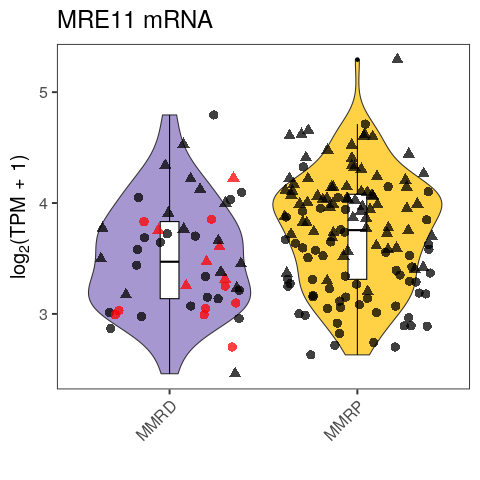

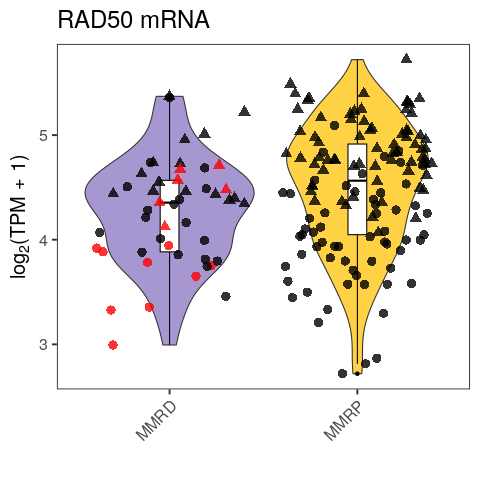

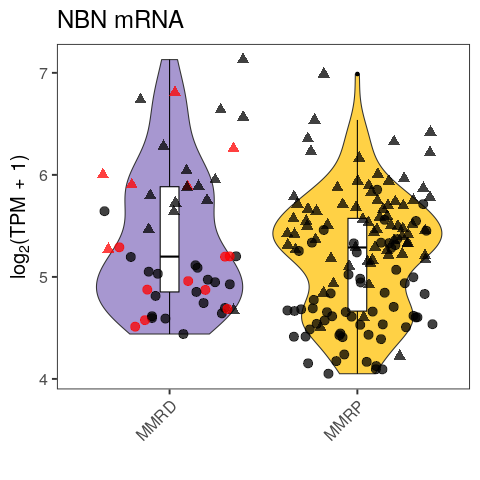

In [195]:
%%R 
MRE11_violin <- ggplot(mmrd_tpm_df, aes(x = MMR_Status, y = ENSG00000020922.13))+
  geom_violin(aes(fill = MMR_Status), varwidth = T, alpha = 0.75)+
  geom_boxplot(width=0.1,colour="black") +
  geom_jitter(alpha = 0.75, aes(colour=factor(RAD50_mutation_color), 
                                shape=factor(cohort_shape)), size=4) +
  scale_colour_manual(name="colour", values=c("black", "red")) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"))+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), 
                                 panel.grid.minor = element_blank())+
  labs(title="MRE11 mRNA", y=expression("log"[2]*"(TPM + 1)"), x= "")+
  theme(axis.text.x=element_text(angle=45, hjust=1),
        legend.position = "none")
NBN_violin <- ggplot(mmrd_tpm_df, aes(x = MMR_Status, y = ENSG00000104320.14))+
  geom_violin(aes(fill = MMR_Status), varwidth = T, alpha = 0.75)+
  geom_boxplot(width=0.1,colour="black") +
  geom_jitter(alpha = 0.75, aes(colour=factor(RAD50_mutation_color), 
                                shape=factor(cohort_shape)), size=4) +
  scale_shape_manual(name='Cancer type', values=c('circle', 'triangle'), 
                     labels=c('UCEC', 'COAD')) +
  scale_colour_manual(name="RAD50 Status", values=c("black", "red"), 
                      labels=c("WT", "Frameshift")) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"), guide="none")+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), 
                                 panel.grid.minor = element_blank())+
  labs(title="NBN mRNA", y= expression("log"[2]*"(TPM + 1)"), x= "")+
  theme(axis.text.x=element_text(angle=45, hjust=1), legend.position="none")
RAD50_violin <- ggplot(mmrd_tpm_df, aes(x = MMR_Status, y = ENSG00000113522.14))+
  geom_violin(aes(fill = MMR_Status), varwidth = T, alpha = 0.75)+
  geom_boxplot(width=0.1,colour="black") +
  geom_jitter(alpha = 0.8, aes(colour=factor(RAD50_mutation_color), 
                               shape=factor(cohort_shape)), size=4) +
  scale_colour_manual(name="colour", values=c("black", "red")) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"))+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), 
                                 panel.grid.minor = element_blank())+
  labs(title="RAD50 mRNA", y= expression("log"[2]*"(TPM + 1)"), x= "")+
  theme(axis.text.x=element_text(angle=45, hjust=1),
        legend.position = "none")

ggsave("Figure_3G_MRE11_violin_rna.pdf", MRE11_violin, path="figures/",
       height=6, width=6, dpi=64)
ggsave("Figure_3G_RAD50_violin_rna.pdf", RAD50_violin, path="figures/", 
       height=6, width=6, dpi=64)
ggsave("Figure_3G_NBN_violin_rna.pdf", NBN_violin, path="figures/",
       height=6, width=6, dpi=64)

print(MRE11_violin)
print(RAD50_violin)
print(NBN_violin)

In [133]:
# Read protein data
prot_df = pd.read_csv(PROTEOME_RAW_PATH, sep='\t', index_col=0).T

In [134]:
# Subset for MMRD tumors
mmrd_prot_df = prot_df.loc[include_mmrd + include_mmrp]

# Annotate mutants
mmrd_prot_df['RAD50_mutation'] = mmrd_prot_df.index.map(
    lambda x: 'RAD50_mutant' if x in rad50_mutants else 'RAD50_WT')
mmrd_prot_df['RAD50_mutation_color'] = mmrd_prot_df['RAD50_mutation'].map(
    lambda x: 'red' if x == 'RAD50_mutant' else 'black')
mmrd_prot_df['cohort'] = mmrd_prot_df.index.map(
    sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort'])
mmrd_prot_df['cohort_shape'] = mmrd_prot_df['cohort'].map({'COAD':'triangle', 'UCEC': 'circle'})

# Annotate MMR status
mmrd_prot_df['MMR_Status'] = mmrd_prot_df.index.map(
    lambda x: 'MMRD' if x in include_mmrd else 'MMRP')

In [135]:
%R -i mmrd_prot_df

Saving 6.67 x 6.67 in image


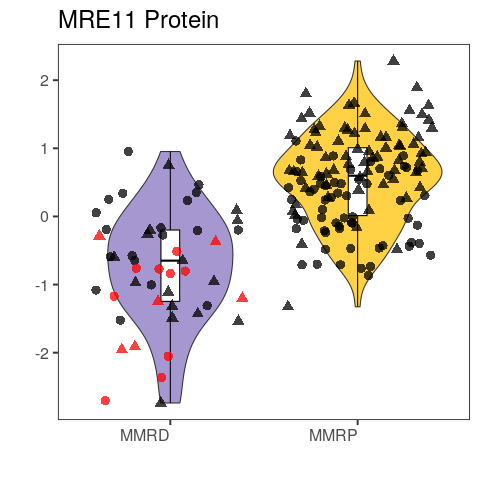

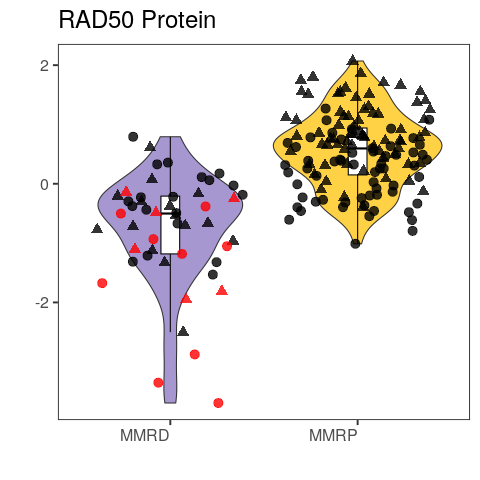

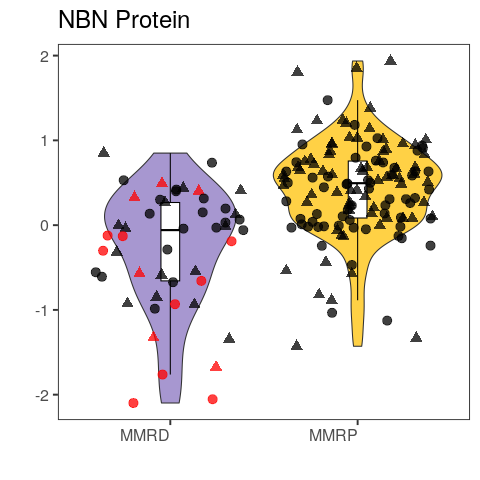

In [198]:
%%R 
yaxis_lab <- expression("\n\nProtein relative\nabundance (log"[2]*" ratio)")
MRE11_violin <- ggplot(mmrd_prot_df, aes(x = MMR_Status, y = MRE11))+
  geom_violin(aes(fill = MMR_Status), varwidth = T, alpha = 0.75, outlier.shape = NA)+
  geom_boxplot(width=0.1,colour="black", outlier.size=-1) +
  geom_jitter(alpha = 0.75, aes(colour=factor(RAD50_mutation_color), 
                                shape=factor(cohort_shape)), size=4) +
  scale_colour_manual(name="colour", values=c("black", "red")) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"))+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), 
                                 panel.grid.minor = element_blank())+
  labs(title="MRE11 Protein", y="", x= "")+
  theme(axis.text.x=element_text(angle=0, hjust=1),
        legend.position = "none")
NBN_violin_legend <- ggplot(mmrd_prot_df, aes(x = MMR_Status, y = NBN))+
  geom_violin(aes(fill = MMR_Status), varwidth = T, alpha = 0.75, outlier.shape = NA)+
  geom_boxplot(width=0.1,colour="black", outlier.size=-1) +
  geom_jitter(alpha = 0.75, aes(colour=factor(RAD50_mutation_color), 
                                shape=factor(cohort_shape)), size=4) +
  scale_shape_manual(name='Cancer type', values=c('circle', 'triangle'), 
                     labels=c('UCEC', 'COAD')) +
  scale_colour_manual(name="RAD50 Status", values=c("black", "red"), 
                      labels=c("WT", "Frameshift")) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"), guide="none")+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), 
                                 panel.grid.minor = element_blank())+
  labs(title="NBN Protein", y= yaxis_lab, x= "")+
  theme(axis.text.x=element_text(angle=0, hjust=1), plot.margin=margin(10, 10, 10, 50))
NBN_violin <- ggplot(mmrd_prot_df, aes(x = MMR_Status, y = NBN))+
  geom_violin(aes(fill = MMR_Status), varwidth = T, alpha = 0.75, outlier.shape = NA)+
  geom_boxplot(width=0.1,colour="black", outlier.size=-1) +
  geom_jitter(alpha = 0.75, aes(colour=factor(RAD50_mutation_color), 
                                shape=factor(cohort_shape)), size=4) +
  scale_shape_manual(name='Cancer type', values=c('circle', 'triangle'), 
                     labels=c('UCEC', 'COAD')) +
  scale_colour_manual(name="RAD50 Status", values=c("black", "red"), 
                      labels=c("WT", "Frameshift")) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"), guide="none")+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), 
                                 panel.grid.minor = element_blank())+
  labs(title="NBN Protein", y= "", x= "")+
  theme(axis.text.x=element_text(angle=0, hjust=1), legend.position="none")
RAD50_violin <- ggplot(mmrd_prot_df, aes(x = MMR_Status, y = RAD50))+
  geom_violin(aes(fill = MMR_Status), varwidth = T, alpha = 0.75, outlier.shape = NA)+
  geom_boxplot(width=0.1,colour="black", outlier.size=-1) +
  geom_jitter(alpha = 0.8, aes(colour=factor(RAD50_mutation_color), 
                               shape=factor(cohort_shape)), size=4) +
  scale_shape_manual(name='Cancer type', values=c('circle', 'triangle'),
                     labels=c('UCEC', 'COAD')) +
  scale_colour_manual(name="colour", values=c("black", "red"),
                      labels=c("WT", "Frameshift")) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"))+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), 
                                 panel.grid.minor = element_blank())+
  labs(title="RAD50 Protein", y="", x= "")+
  theme(axis.text.x=element_text(angle=0, hjust=1), legend.position="none")

MRE11_violin
RAD50_violin
NBN_violin
NBN_violin_legend
ggsave("Figure_3G_MRE11_violin_prot.pdf", MRE11_violin, path="figures/",
       height=6, width=6, dpi=64)
ggsave("Figure_3G_RAD50_violin_prot.pdf", RAD50_violin, path="figures/", 
       height=6, width=6, dpi=64)
ggsave("Figure_3G_NBN_violin_prot.pdf", NBN_violin, path="figures/", 
       height=6, width=6, dpi=64)
ggsave("Figure_3G_legend.pdf", NBN_violin_legend, path="figures/")
print(MRE11_violin)
print(RAD50_violin)
print(NBN_violin)